# Training the Hypersolver - Plotting Results

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import sys; sys.path.append(2*'../') # go 2 dirs back
from src import *
from math import pi
import matplotlib


In [2]:
device = 'cpu'

In [3]:
ControlledSystem = QuadcopterGym


## Generate distribution of initial conditions

In [4]:
from torch.distributions import Uniform

low = -torch.ones(12).to(device)
high = torch.ones(12).to(device)
low[0:3]*=5
high[0:3]*=5
low[3:6]*=50
high[3:6]*=50
low[6:9]*=50
high[6:9]*=50
low[9:12]*=100
high[9:12]*=100

dist = Uniform(low, high)
print(dist.sample_n(2))

tensor([[  2.2692,   0.4009,  -1.4150, -12.4893,  -9.8831, -36.9169, -34.7797,
         -15.0665,  21.2993,  78.6990,  23.4708, -45.4064],
        [ -4.2104,   2.8153,  -2.3430, -28.1650,  13.6959, -21.1912, -24.7754,
          39.9353, -39.5445, -51.5116,  72.7932, -40.0482]])


/home/botu/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:161: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


## New output scaling
Since position and angular positions derivatives $\dot{x},~\dot{\psi}$ propagated via the augmented state without any calculation, then there is no need to add an additional term. Indeed, doing so would just degrade the performance unless it was always 0. So we put the output scaling to 0 for updates on positions and angular positions

In [5]:
in_scal = torch.cat([1/high, 1/high])
u_scal = 1/20000*torch.ones(4).to(device)
in_scal = torch.cat([in_scal, u_scal])

out_scal = high

# Zero out positions contribution term
out_scal[0:6] = 0 
print('Input scaling:\n', in_scal)
print('Output scaling:\n', out_scal)

Input scaling:
 tensor([2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-02, 2.0000e-02, 2.0000e-02,
        2.0000e-02, 2.0000e-02, 2.0000e-02, 1.0000e-02, 1.0000e-02, 1.0000e-02,
        2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-02, 2.0000e-02, 2.0000e-02,
        2.0000e-02, 2.0000e-02, 2.0000e-02, 1.0000e-02, 1.0000e-02, 1.0000e-02,
        5.0000e-05, 5.0000e-05, 5.0000e-05, 5.0000e-05])
Output scaling:
 tensor([  0.,   0.,   0.,   0.,   0.,   0.,  50.,  50.,  50., 100., 100., 100.])


### Scaling
We could apply a residual loss with scaling so to give the same "importance" to all of the parameters

In [6]:
Δt = 0.02

x_min_train, x_max_train = -1000, 1000

bs_hs = 1024
n_grid = 100



## Hypersolver

In [7]:

hdim = 64

class Hypersolver(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(28, hdim),
            nn.Softplus(),
        #     Snake(hdim),
            nn.Linear(hdim, hdim),
            nn.Softplus(),
        #     Snake(hdim),
            nn.Linear(hdim, 12)]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, t, x):
        x = x*in_scal
        x = self.layers(x)
        x = x*out_scal
        return x
    
hs = torch.load('saved_models/hypersolver_0.02_new_quadcopter.pt')

## Residuals

In [11]:
def calculate_residuals(X, u, Δt, method, hypereuler=None):
    t_span = torch.tensor([0, Δt]).to(device)
    with torch.no_grad():
        x_fine = odeint(ControlledSystem(u)._dynamics, X, t_span, method='dopri5')[-1]
        if hypereuler:
            xfu = torch.cat([X, ControlledSystem(u)._dynamics(0, X), u.u0], -1)
            x_coarse =  X + Δt*ControlledSystem(u)._dynamics(0, X) + (Δt**2)*hypereuler(0, xfu)
        else:
            x_coarse = odeint(ControlledSystem(u)._dynamics, X, t_span, method=method)[-1]
    return torch.norm(((x_fine - x_coarse)), p=2, dim=-1)

In [12]:
u_rand = RandConstController((3, 3), 1, 1)
drone = ControlledSystem(u_rand)
max_controller = drone.MAX_RPM

bs = 1000
x = dist.sample((bs,)).to(device)
u_rand.u0 = torch.Tensor(bs, 4)[None].uniform_(0, max_controller).to(device)

res_hypereuler = calculate_residuals(x[None], u_rand, Δt, 'euler', hypereuler=hs)
res_euler = calculate_residuals(x[None], u_rand, Δt, 'euler')
res_midpoint = calculate_residuals(x[None], u_rand, Δt, 'midpoint')
res_rk4 = calculate_residuals(x[None], u_rand, Δt, 'rk4')

In [13]:
res_he = res_hypereuler.squeeze(0).cpu().numpy()
res_eu = res_euler.squeeze(0).cpu().numpy()
res_mp = res_midpoint.squeeze(0).cpu().numpy()
res_rk = res_rk4.squeeze(0).cpu().numpy()

In [31]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

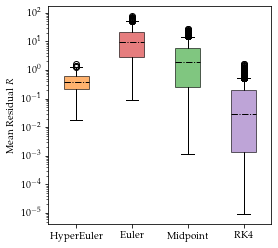

In [36]:
colors = [ 'tab:orange', 'tab:red', 'tab:green', 'tab:purple']
labels = [ 'HyperEuler','Euler', 'Midpoint', 'RK4']


fig, ax = plt.subplots(1,1, figsize=(4,4))

bp = ax.boxplot([res_he, res_eu, res_mp, res_rk],
                patch_artist=True, labels=labels)
for b, m, c in zip(bp['boxes'], bp['medians'], colors):
    b.set_facecolor(c)
    b.set_alpha(0.6)
    m.set(color='black', linestyle='-.')
ax.set_yscale('log')
# ax.set_ylim(0, 0.02)
# ax.set_title('Quadcopter residuals distribution')
ax.set_ylabel(r'Mean Residual $R$')

# ## Saving
import tikzplotlib
fig.savefig('media/quadcopter_residuals.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/quacopter_residuals.tex")